# Machine Learning Problem

The dataset is weather data from the edmonton city-center from 1961 to 1994

The goal is to predict weather "descriptions" (i.e. cloudy, snow, rain etc) from features (temperature, relhumidity, pressure)

&nbsp;
&nbsp;
&nbsp;
   
Inputs are: temperature (°c), relative humidity (%), and pressure (kPa)

Output: a weather description in the following set {Clear, Cloudy, Fog, Ice Crystals, Mainly Clear, Mostly Cloudy, Rain, Rain Showers, Snow}

## Classifiers
I choose 3 classifiers + the baseline to explore the performance of different algorithms, all using the
scikit-learn implementations
\begin{itemize}
    \item There's the obvious baseline of a $\frac{1}{k}$ zero-classifier, which we will hopefully outperform
    \item Linear regression as a basic model
    \item SVM (sklearn SVC)
    \item and a relatively simple multi-layer perceptron neural net from SKLearn (sklearn MLPClassifier)
\end{itemize}

In [1]:
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# GLOBALS
# the size of the test and validation splits
TEST_SIZE = 0.2
# our random seed to use
RANDOM_STATE = 69

# Data

We're trying to predict the weather column of this data, which has 178 different labels, which is too much to
reasonably classify in this project, so I filter the dataset to only use the top 10 classes, which make up ~95% of the data anyways

I also remove any rows containing NaN

Since my dataset is pretty unbalanced I choose to take ~10000 samples from each class to build up the dataset 

In [3]:
# load in data
data = pd.read_csv("weather_data.csv")

# extract classes and counts
classes, counts = np.unique(data[['Weather']].values, return_counts=True)
classes = sorted(list(zip(classes, counts)), key=lambda x: -x[1])[:9]
print("Classes with counts are : {}".format(classes))
classes = list(map(lambda x: x[0], classes))

data = data[['TempC','RelHumPct', 'PkPa', 'Weather']].loc[data['Weather'].isin(classes)].dropna()

# 
data = data.groupby('Weather').apply(lambda x: x.sample(min(len(x), 10000)))

Classes with counts are : [('Mostly Cloudy', 121373), ('Mainly Clear', 99069), ('Cloudy', 45023), ('Clear', 31173), ('Snow', 25218), ('Rain Showers', 6916), ('Rain', 6347), ('Fog', 5068), ('Ice Crystals', 3636)]


In [4]:
X = data[['TempC', 'RelHumPct', "PkPa"]]
y = data[['Weather']]

### Train, validation, test
I use built-in scikit-learn train_test_split to split the data into train and test datasets 
In this step I only split into train and test datasets, since I will be using built in k-fold validation which does
the splits automatically (only on the training data of course, the test data is still completely separate)

I extract both a unscaled X_train... and a 
scaled X_train_scaled... (using a minmax scaler)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = RANDOM_STATE)

# scale a copy of the data (y is just classes so doesn't need to be scaled)
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
# we're using the same random state as the other split, so we don't need to worry about
# pulling out the y values from it
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, test_size=TEST_SIZE, 
                                                       random_state = RANDOM_STATE)

# Classifiers

Here I train, validate and test all 4 classifiers, reporting the accuracy and a balanced accuracy score.
I use accuracy here because it's a simple metric to intuitively understand, and balanced accuracy since it averages recall per class, which handles the imbalanced classes a little better
differently for different labels

For each classifier I also output the detailed classification report from sklearn.metrics classification_report. This is to give me an idea of what's going on with the other usual metrics, but I'm still generally focussing on the balanced accuracy score for these classifiers.

## Baseline Classifier

As a baseline, I use the scikit-learn DummyClassifier using the "most_frequent" strategy
which is simply a max class classifier as well as the "uniform" strategy which just generates predictions
uniformly at random across the classes.

I would expect this to perform the worst out of the 4 classifiers

In the detailed report, zeros are just due to the most_frequent classifier never classifying the smaller classes
and so precision and recall cannot be calculated without a zero-division. zeros are to be ignored.

In [6]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_hat = dummy.predict(X_test)
print("Detailed Report:")
print()
print(classification_report(y_test, y_hat, zero_division=0))
print("~"*60)
print("Dummmy classifier (most frequent) has accuracy {:f}".format(accuracy_score(y_test, y_hat)))
print("Dummmy classifier (most frequent) has balanced accuracy score {:f}\n".format(balanced_accuracy_score(y_test, y_hat)))

dummy = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_hat = dummy.predict(X_test)
print("Detailed Report:")
print()
print(classification_report(y_test, y_hat, zero_division=0))
print("~"*60)
print("Dummmy classifier (uniform) has accuracy {:f}".format(accuracy_score(y_test, y_hat)))
print("Dummmy classifier (uniform) has balanced accuracy score {:f}".format(balanced_accuracy_score(y_test, y_hat)))

Detailed Report:

               precision    recall  f1-score   support

        Clear       0.00      0.00      0.00      2010
       Cloudy       0.14      1.00      0.24      1979
          Fog       0.00      0.00      0.00       975
 Ice Crystals       0.00      0.00      0.00       758
 Mainly Clear       0.00      0.00      0.00      2009
Mostly Cloudy       0.00      0.00      0.00      1989
         Rain       0.00      0.00      0.00      1269
 Rain Showers       0.00      0.00      0.00      1406
         Snow       0.00      0.00      0.00      1999

     accuracy                           0.14     14394
    macro avg       0.02      0.11      0.03     14394
 weighted avg       0.02      0.14      0.03     14394

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Dummmy classifier (most frequent) has accuracy 0.137488
Dummmy classifier (most frequent) has balanced accuracy score 0.111111

Detailed Report:

               precision    recall  f1-score   support

 

### Results

Both the dummmy classifiers perform exactly as well as expected, since a little more than 10% of the data is "mostly cloudy", and there are 10 classes so the balanced accuracy score is going to be 10%. For the uniform classifier, both values are around 10% which is exactly as expected for a random uniform classifier

## Logistic Regression

My first model is a Logistic Regression classifier,
I use the scikit-learn LogisticRegression and use validation_curve to do cross-fold validation, I then train the model using the best parameters as determined in the validation. I just use the default
stratified k-folds built in which should be good enough. NUM_FOLDS can be tuned as needed, as can MAX_ITER

I use balanced_accuracy_score for my scoring, since that's my favoured measure of quality in this experiment

In [7]:
%%time

# number of validation folds for k-fold cross validation
NUM_FOLDS = 10
# maximum iterations when training our classifier
MAX_ITER = 1000

logit = LogisticRegression(max_iter=MAX_ITER, class_weight="balanced")

param_range = np.array([1, 10, 100, 1000])
train_scores, test_scores = validation_curve(logit, X_train_scaled, np.ravel(y_train), 
                                             param_name="C", cv=NUM_FOLDS, n_jobs=-1,
                                             param_range=param_range, scoring="balanced_accuracy")

CPU times: user 344 ms, sys: 453 ms, total: 797 ms
Wall time: 41.6 s


I plot the validation curve as I adjust the regularization strength of the model

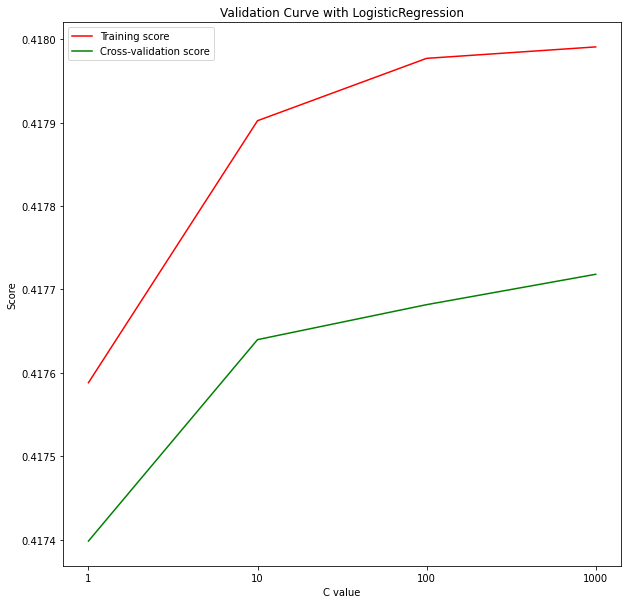

In [8]:
%matplotlib inline

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
_ = plt.figure(figsize=(10,10))
_ = plt.title("Validation Curve with LogisticRegression")
_ = plt.xlabel("C value")
_ = plt.ylabel("Score")
_ = plt.plot(np.arange(len(param_range)), train_scores_mean, label="Training score", color="r")
_ = plt.plot(np.arange(len(param_range)), test_scores_mean, label="Cross-validation score", color="g")
_ = plt.legend(loc="best")
_ = plt.xticks(np.arange(len(param_range)), param_range)

We see the model perform the best with higher C values, meaning a lower regularization performs better, I then test the performance of the model using these parameters

In [9]:
# find the best C value from our validation
best_C = param_range[np.argmax(np.mean(test_scores, axis=1))]
print("Best C is: {}".format(best_C))

Best C is: 1000


In [10]:
logit.C = best_C
logit.fit(X_train_scaled, np.ravel(y_train))
y_hat = logit.predict(X_test_scaled)
print("Detailed Report:")
print()
print(classification_report(y_test, y_hat))
print("~"*60)
print("Logistic Regression classifier has accuracy {:f}".format(accuracy_score(y_test, y_hat)))
print("Logistic Regression has balanced accuracy score {:f}".format(balanced_accuracy_score(y_test, y_hat)))

Detailed Report:

               precision    recall  f1-score   support

        Clear       0.34      0.28      0.31      2010
       Cloudy       0.29      0.22      0.25      1979
          Fog       0.38      0.70      0.50       975
 Ice Crystals       0.37      0.70      0.48       758
 Mainly Clear       0.36      0.30      0.32      2009
Mostly Cloudy       0.30      0.14      0.19      1989
         Rain       0.42      0.66      0.51      1269
 Rain Showers       0.30      0.40      0.34      1406
         Snow       0.47      0.36      0.41      1999

     accuracy                           0.36     14394
    macro avg       0.36      0.42      0.37     14394
 weighted avg       0.36      0.36      0.34     14394

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Logistic Regression classifier has accuracy 0.362026
Logistic Regression has balanced accuracy score 0.417568


### Results

As can be seen, there's a pretty significant increase in accuracy, with us a roughly ~42% balanced accuracy and ~36% lower regular accuracy.

This is significantly better than the dummmy classifier as we would expect, and considering this is a dataset with 10 classes, is actually pretty impressive for logistic regression. I suspect the SVM will outperform these results, and so we'll see how impressive this performance really is as we evalutate the last two classifiers

## SVM

I use an svm classifier next. I use sklearn SVC as my support vector classifier

I tune the gamma and C hyperparameters as well as testing both the linear and rbf kernels.

In [11]:
%%time

parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm = GridSearchCV(SVC(class_weight='balanced'), parameters, verbose=True, 
                   scoring="balanced_accuracy", n_jobs=-1, cv=NUM_FOLDS)

svm.fit(X_train_scaled, np.ravel(y_train))
print("Best parameters are:")
print(svm.best_params_)
print("~"*60)
print("Grid Scores:")
print()
means = svm.cv_results_['mean_test_score']
stds = svm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svm.cv_results_['params']):
    print("{:f} +-{:f} for {}".format(mean, 2 * std, params))
print("~"*60)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 30.9min finished


Best parameters are:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Grid Scores:

0.325920 +-0.021484 for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.113689 +-0.015465 for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.408847 +-0.010088 for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.329409 +-0.026324 for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.424392 +-0.011982 for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.408883 +-0.010108 for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.426200 +-0.009889 for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.424392 +-0.012134 for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.425612 +-0.010325 for {'C': 1, 'kernel': 'linear'}
0.425949 +-0.009521 for {'C': 10, 'kernel': 'linear'}
0.425959 +-0.009812 for {'C': 100, 'kernel': 'linear'}
0.425798 +-0.009658 for {'C': 1000, 'kernel': 'linear'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CPU times: user 1min 42s, sys: 344 m

In [12]:
y_hat = svm.predict(X_test_scaled)
print("Detailed Report:")
print()
print(classification_report(y_test, y_hat))
print("~"*60)

print("SVC has accuracy {:}".format(accuracy_score(y_test, y_hat)))
print("SVC has balanced accuracy score {:f}".format(balanced_accuracy_score(y_test, y_hat)))

Detailed Report:

               precision    recall  f1-score   support

        Clear       0.35      0.25      0.29      2010
       Cloudy       0.30      0.23      0.26      1979
          Fog       0.38      0.68      0.49       975
 Ice Crystals       0.35      0.73      0.47       758
 Mainly Clear       0.35      0.33      0.34      2009
Mostly Cloudy       0.31      0.12      0.18      1989
         Rain       0.46      0.66      0.54      1269
 Rain Showers       0.33      0.46      0.38      1406
         Snow       0.45      0.36      0.40      1999

     accuracy                           0.37     14394
    macro avg       0.36      0.43      0.37     14394
 weighted avg       0.36      0.37      0.35     14394

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SVC has accuracy 0.36800055578713353
SVC has balanced accuracy score 0.425003


### Results

As we can see above, the SVM doesn't perform particularly differently from the logistic regression classifier, which is surprising to me as I would've expected to see the SVM outperform the logistic regression classifier at least by a bit, but seeing as the best parameters chosen used a linear kernel, it would lead me to believe that my data is relatively linear and thus the logistic regression should perform reasonably well.

Also the linear kernel would mean that both the SVM and logistic regression are trying to solve a linear problem, and thus should achieve somewhat similar results.

Despite performing roughly the same, the SVM has a major downside compared to the logit, in that the training time is significantly higher at around 15 minutes including hyperparameter tuning. So in practice, given that both SVM and logistic regression are performing about the same, I would prefer to use logistic regression most of the time due to the significantly reduced training cost.

## MLPClassifier

I use sklearn's Multi-layer perceptron classifier here for my simple neural net, 

In [15]:
%%time

parameters={
    'learning_rate': ["constant", "adaptive", "invscaling"],
    'hidden_layer_sizes': [(100,), (100, 100), (50, 50, 50, 50)],
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'solver': ['adam'], # I tested with SGD and lbfgs, but results were poor for both,
                        # so i'm going with adam here
    'activation': ["relu", "tanh", "logistic"] # I tested with logistic, but results were poor
}

mlp = GridSearchCV(MLPClassifier(), parameters, verbose=True, 
                   scoring="balanced_accuracy", n_jobs=-1, cv=NUM_FOLDS)

mlp.fit(X_train_scaled, np.ravel(y_train))
print("Best parameters are:")
print(mlp.best_params_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 65.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 120.7min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 175.3min finished


Best parameters are:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
CPU times: user 2min 53s, sys: 4min 35s, total: 7min 29s
Wall time: 2h 56min 22s


In [16]:
y_hat = mlp.predict(X_test_scaled)
print("Detailed Report:")
print()
print(classification_report(y_test, y_hat))
print("~"*60)

print("MLP has accuracy {:}".format(accuracy_score(y_test, y_hat)))
print("MLP has balanced accuracy score {:f}".format(balanced_accuracy_score(y_test, y_hat)))

Detailed Report:

               precision    recall  f1-score   support

        Clear       0.34      0.34      0.34      2010
       Cloudy       0.33      0.22      0.26      1979
          Fog       0.56      0.49      0.52       975
 Ice Crystals       0.45      0.52      0.48       758
 Mainly Clear       0.36      0.28      0.31      2009
Mostly Cloudy       0.28      0.18      0.22      1989
         Rain       0.49      0.64      0.55      1269
 Rain Showers       0.36      0.51      0.42      1406
         Snow       0.45      0.65      0.53      1999

     accuracy                           0.40     14394
    macro avg       0.40      0.42      0.40     14394
 weighted avg       0.38      0.40      0.38     14394

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MLP has accuracy 0.39745727386411006
MLP has balanced accuracy score 0.424501


### Results

As can be clearly seen, the model performs roughly on par with the other models in accuracy, but with a better f1-score. This model does of course come with the usual large downside of neural networks that the parameter tuning takes a long time, and in this case due to the lack of significant difference in performance compared to the other models, I would prefer to choose one of the other models over this one.

It's very possible that there are parameters for this neural network that would perform better that I didn't check, but based on my testing I would be inclined to believe it wouldn't perform significantly better.

# Overall Results

Overall, we see all 3 models significantly outperform the baseline classifier as we would expect, and more unexpectedly see all 3 models perform roughly the same overall.

This leads to a hypothesis of mine that certain classes are just difficult to guess based on the inputs, since I only provide temperature, pressure and humidity data as inputs, and those inputs may not provide sufficient information to infer the weather tags for certain types of weather such as "mostly cloudy". It would be interesting to do some statistical analysis to see how the inputs correlate with the outputs, but that's out of the scope of this project at the moment.

In the end, I'm still  impressed at being able to guess weahter descriptions with a ~40-43% accuracy rate, especially since weather realted data is a notoriously difficult to predict. It would also be interesting as a bit of future work to explore a few more algorithms to see if they will also perform at the same ~40-43% accuracy, but I'm inclined to believe that this would hold for many algorithms I could throw at this problem.